In [7]:
import torch
import numpy as np

from model.vocabulary import SMILESTokenizer
from model.utils import reverse_smiles
from model.rnn import Model
from model import utils
from IPython.display import display

from rdkit.Chem import Draw, Descriptors
from rdkit.Chem import AllChem as Chem

def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

## Test SMILES reversal

In [8]:
from model.vocabulary import SMILESTokenizer
import re

In [74]:
def test_smiles_eq(smi1, smi2):
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    # Parse them
    if not mol1:
        return False, f'Parsing error: {smi1}'
    if not mol2:
        return False, f'Parsing error: {smi2}'
    # Remove atom map
    for mol in [mol1, mol2]:
        for atom in mol.GetAtoms():
            atom.SetAtomMapNum(0)
    # Check smiles are the same
    nsmi1 = Chem.MolToSmiles(mol1)
    nsmi2 = Chem.MolToSmiles(mol2)
    if nsmi1 != nsmi2:
        return False, f'Inequivalent SMILES: {nsmi1} vs {nsmi2}'
    # Check InChi
    inchi1 = Chem.MolToInchi(mol1)
    inchi2 = Chem.MolToInchi(mol2)
    if inchi1 != inchi2:
        return False, f'Inequivalent InChi\'s'
    return True, ""

def reverse_smiles(smiles, renumber_rings=False, v=False):
    """
    Reverse smiles while maintaining syntax
    """
    if v: print(f'Reversing: {smiles}')
    # REGEX
    square_brackets = re.compile(r"(\[[^\]]*\])")
    brcl = re.compile(r"(Br|Cl)")
    rings = re.compile(r"([a-zA-Z][0-9]+)")
    double_rings = re.compile(r"([0-9]{2})")

    # Find parenthesis indexes
    open_count = 0
    close_count = 0
    open_close_idxs = []
    for i, t in enumerate(smiles):
        # Open
        if (t == '(') and (open_count == 0):
            # Grab branch source
            find_source = True
            count_back = 1
            while find_source:
                if re.match("[a-zA-Z]", smiles[i-count_back]):
                    open_close_idxs.append(i-count_back)
                    find_source = False
                else:
                    count_back += 1
            open_count += 1
        elif t == '(':
            open_count += 1

        # Close
        elif t == ')':
            close_count += 1

            # Look forward to see if another bracket comes straight after
            if smiles[i+1] == '(':
                continue

            if open_count == close_count:
                open_close_idxs.append(i)
                open_count = 0
                close_count = 0
        else:
            pass
    if v: print(f'Parenthesis identified:\n\t {open_close_idxs}')

    # Split by parenthesis indexes
    splitted = []
    for i in range(0, len(open_close_idxs), 2):
        # Add before bracket bit
        if i == 0:
            splitted.append(smiles[:open_close_idxs[i]])
        else:
            splitted.append(smiles[open_close_idxs[i-1]+1: open_close_idxs[i]])
        # Add bracket
        splitted.append(smiles[open_close_idxs[i]:open_close_idxs[i+1]+1])
    # Add bit after
    if len(open_close_idxs) > 0:
        splitted.append(smiles[open_close_idxs[-1]+1:])
    # Remove blanks
    splitted = [s for s in splitted if s != '']
    if v: print(f'Parenthesis split:\n\t {splitted}')

    # Split regex outside parenthesis
    pre_split = [re.compile("\)$")] # Ends in brackets
    for regex in [square_brackets, brcl, rings, double_rings]:
        new_splitted = []
        for i, t in enumerate(splitted):
            if any([avoid.search(t) for avoid in pre_split]):
                new_splitted.extend([t])
            else:
                new_split = [s for s in regex.split(t) if s != '']
                new_splitted.extend(new_split)
        splitted = new_splitted
        pre_split.append(regex)
    if v: print(f'Tokenize outside:\n\t {splitted}')

    # Now we split everything else
    new_splitted = []
    for i, t in enumerate(splitted):
        if any([avoid.search(t) for avoid in pre_split]):
            new_splitted.extend([t])
        else:
            new_splitted.extend(list(t))
    splitted = new_splitted
    if v: print(f'Tokenize anything else:\n\t {splitted}')

    # Add correction for rings following square brackets not picked up
    new_splitted = []
    for i, t in enumerate(splitted):
        if re.match("[0-9]+", t) and re.match("^\[.*\]$", splitted[i-1]):
            new_splitted.pop(-1)
            new_splitted.append(splitted[i-1] + t)
        else:
            new_splitted.append(t)
    splitted = new_splitted
    if v: print(f'Correct rings following square brackets:\n\t {splitted}')

    # Reverse the tokens
    rsplitted = list(reversed(splitted))
    rsmiles = "".join(rsplitted)
    if v: print(f'Reversed tokens:\n\t {rsplitted}')
    if v: print(f'Reversed smiles:\n\t {rsmiles}')

    # Re-number the rings in order of appearance
    if renumber_rings:
        # WARNING: Limited to < 10 rings as treats each number as an individual ring
        ring_map = {}
        ring_count = 1
        square_brackets = False
        new_rsmiles = ""
        for ci, c in enumerate(rsmiles):
            # First evaluate if we are in square brackets
            if c == '[':
                square_brackets = True
            if c == ']':
                square_brackets = False
            if not square_brackets:
                # Check for number
                if re.search("[0-9]", c):
                    # Add to ring map
                    if c not in ring_map.keys(): #not any([rn == mi for mi, mo in ring_map]):
                        ring_map[c] = str(ring_count) #.append((rn, str(ring_count)))
                        ring_count += 1
                    # Update c
                    c = ring_map[c]
            # Add token
            new_rsmiles += c
        rsmiles = new_rsmiles
        if v: print(f'Rings reindexed:\n\t {rsmiles}')
            
    return rsmiles

In [71]:
x = re.search(".([0-9]{1})$|.([0-9]{2})$", "c1")
for m in x.groups():
    if m: break
#x.group()
#re.sub("[0-9]{1}$|[0-9]{2}$", "1", "c12")
re.match("[0-9]", "1")

<re.Match object; span=(0, 1), match='1'>

In [75]:
test_smiles = [
    'CCOC(C=Cc1ccccc1)=C1C(=O)C=C(C)C1=O',
    'COCCOC(=O)c1cc(C(=O)c2cc(F)ccc2O)coc1=N',
    'COc1ccccc1C=CC(=O)c1cccc([N+](=O)[O-])c1',
    'Cc1nn(C)c2nc3ccccc3c(NCCN3CCCC3)c12',
    'Nc1nc(COc2ccc3ccccc3c2)cs1',
    'CC(=O)c1cccc(-c2nn(C(C)C)c3ncnc(N)c23)c1',
    'CCNCC1OC(n2cc(C)c(=O)[nH]c2=O)CC1O',
    'CNc1nc(NC2(C#N)CCCCC2)nc(SC)n1',
    'N#CC1(c2cc(-c3cnc(N)nc3)nc(N3CC4CC3C4)n2)CCC1',
    'COC(=O)c1cnc2[nH]c(=O)n(C(C)c3ccccc3)c2n1'
]

In [76]:
for smi in test_smiles:
    p, _ = test_smiles_eq(smi, reverse_smiles(smi, renumber_rings=True, v=False))
    print(p)

True
True
True
True
True
True
True
True
True
True


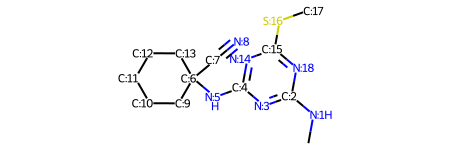

In [68]:
smiles=test_smiles[-3]
mol_with_atom_index(Chem.MolFromSmiles(smiles))

Reversing: Cc1nn(C)c2nc3ccccc3c(NCCN3CCCC3)c12
Parenthesis identified:
	 [4, 7, 19, 31]
Parenthesis split:
	 ['Cc1n', 'n(C)', 'c2nc3ccccc3', 'c(NCCN3CCCC3)', 'c12']
Tokenize outside:
	 ['C', 'c1', 'n', 'n(C)', 'c2', 'n', 'c3', 'cccc', 'c3', 'c(NCCN3CCCC3)', 'c12']
Tokenize anything else:
	 ['C', 'c1', 'n', 'n(C)', 'c2', 'n', 'c3', 'c', 'c', 'c', 'c', 'c3', 'c(NCCN3CCCC3)', 'c12']
Correct rings following square brackets:
	 ['C', 'c1', 'n', 'n(C)', 'c2', 'n', 'c3', 'c', 'c', 'c', 'c', 'c3', 'c(NCCN3CCCC3)', 'c12']
Reversed tokens:
	 ['c12', 'c(NCCN3CCCC3)', 'c3', 'c', 'c', 'c', 'c', 'c3', 'n', 'c2', 'n(C)', 'n', 'c1', 'C']
Reversed smiles:
	 c12c(NCCN3CCCC3)c3ccccc3nc2n(C)nc1C


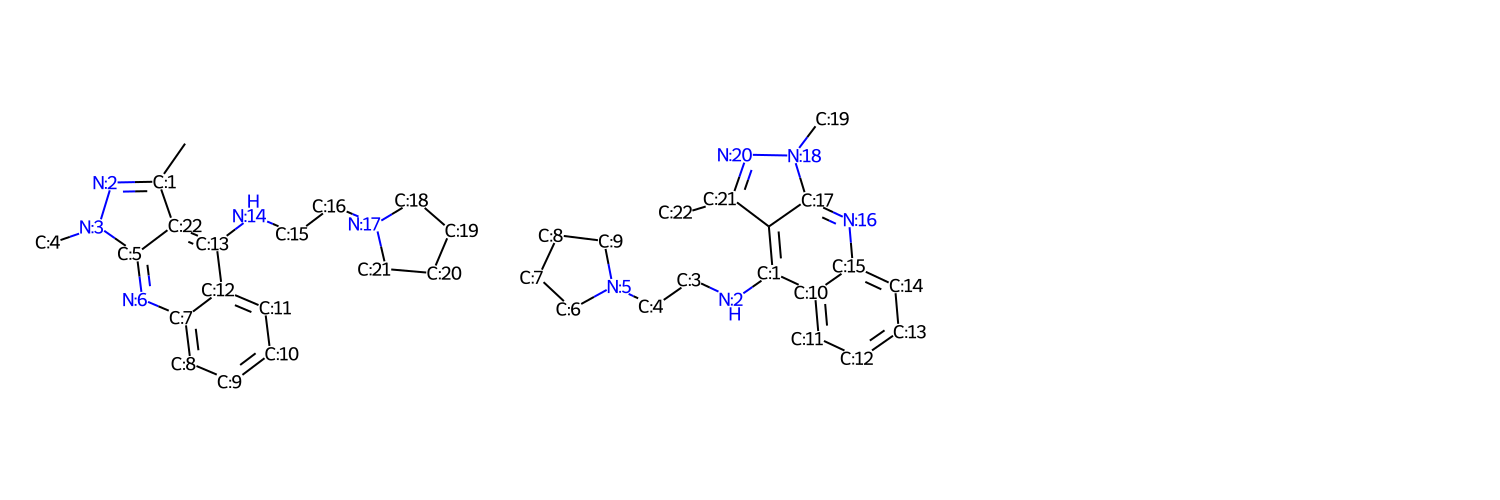

In [79]:
# Check that if you add (*) for a decoration point, it will be reversed properly
tsmiles = test_smiles[3]
#tsmiles = 'C(OCCOC(=O)c1c(=N)occ(C(c2c(O)ccc(F)c2)=O)c1)*'
rtsmiles = reverse_smiles(smiles=tsmiles, renumber_rings=False, v=True)
Draw.MolsToGridImage(mols=[mol_with_atom_index(Chem.MolFromSmiles(smi)) for smi in [tsmiles, rtsmiles]], subImgSize=(500,500))

*COc1ccccc1C=CC(=O)c1cccc([N+](=O)[O-])c1


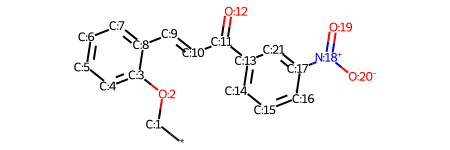

In [14]:
# Atom order is order of SMILES
tsmiles = test_smiles[2]
tsmiles = '*'+tsmiles
print(tsmiles)
mol = Chem.MolFromSmiles(tsmiles)
mol_with_atom_index(mol)

*COCCOC(=O)c1c(*)c(C(=O)c2cc(F)ccc2O)coc1=N


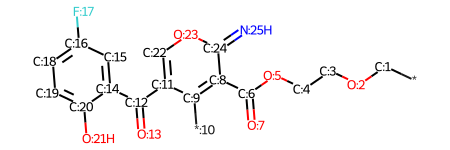

Randomized from same root
['c1(*)c(C(=O)c2c(O)ccc(F)c2)coc(=N)c1C(=O)OCCOC*', 'c1(*)c(C(=O)OCCOC*)c(=N)occ1C(=O)c1c(O)ccc(F)c1', 'c1(*)c(C(c2c(O)ccc(F)c2)=O)coc(=N)c1C(=O)OCCOC*', 'c1(*)c(C(OCCOC*)=O)c(=N)occ1C(c1c(O)ccc(F)c1)=O', 'c1(*)c(C(=O)c2c(O)ccc(F)c2)coc(=N)c1C(OCCOC*)=O', 'c1(*)c(C(=O)c2cc(F)ccc2O)coc(=N)c1C(=O)OCCOC*', 'c1(*)c(C(OCCOC*)=O)c(=N)occ1C(=O)c1cc(F)ccc1O', 'c1(*)c(C(=O)OCCOC*)c(=N)occ1C(c1c(O)ccc(F)c1)=O']


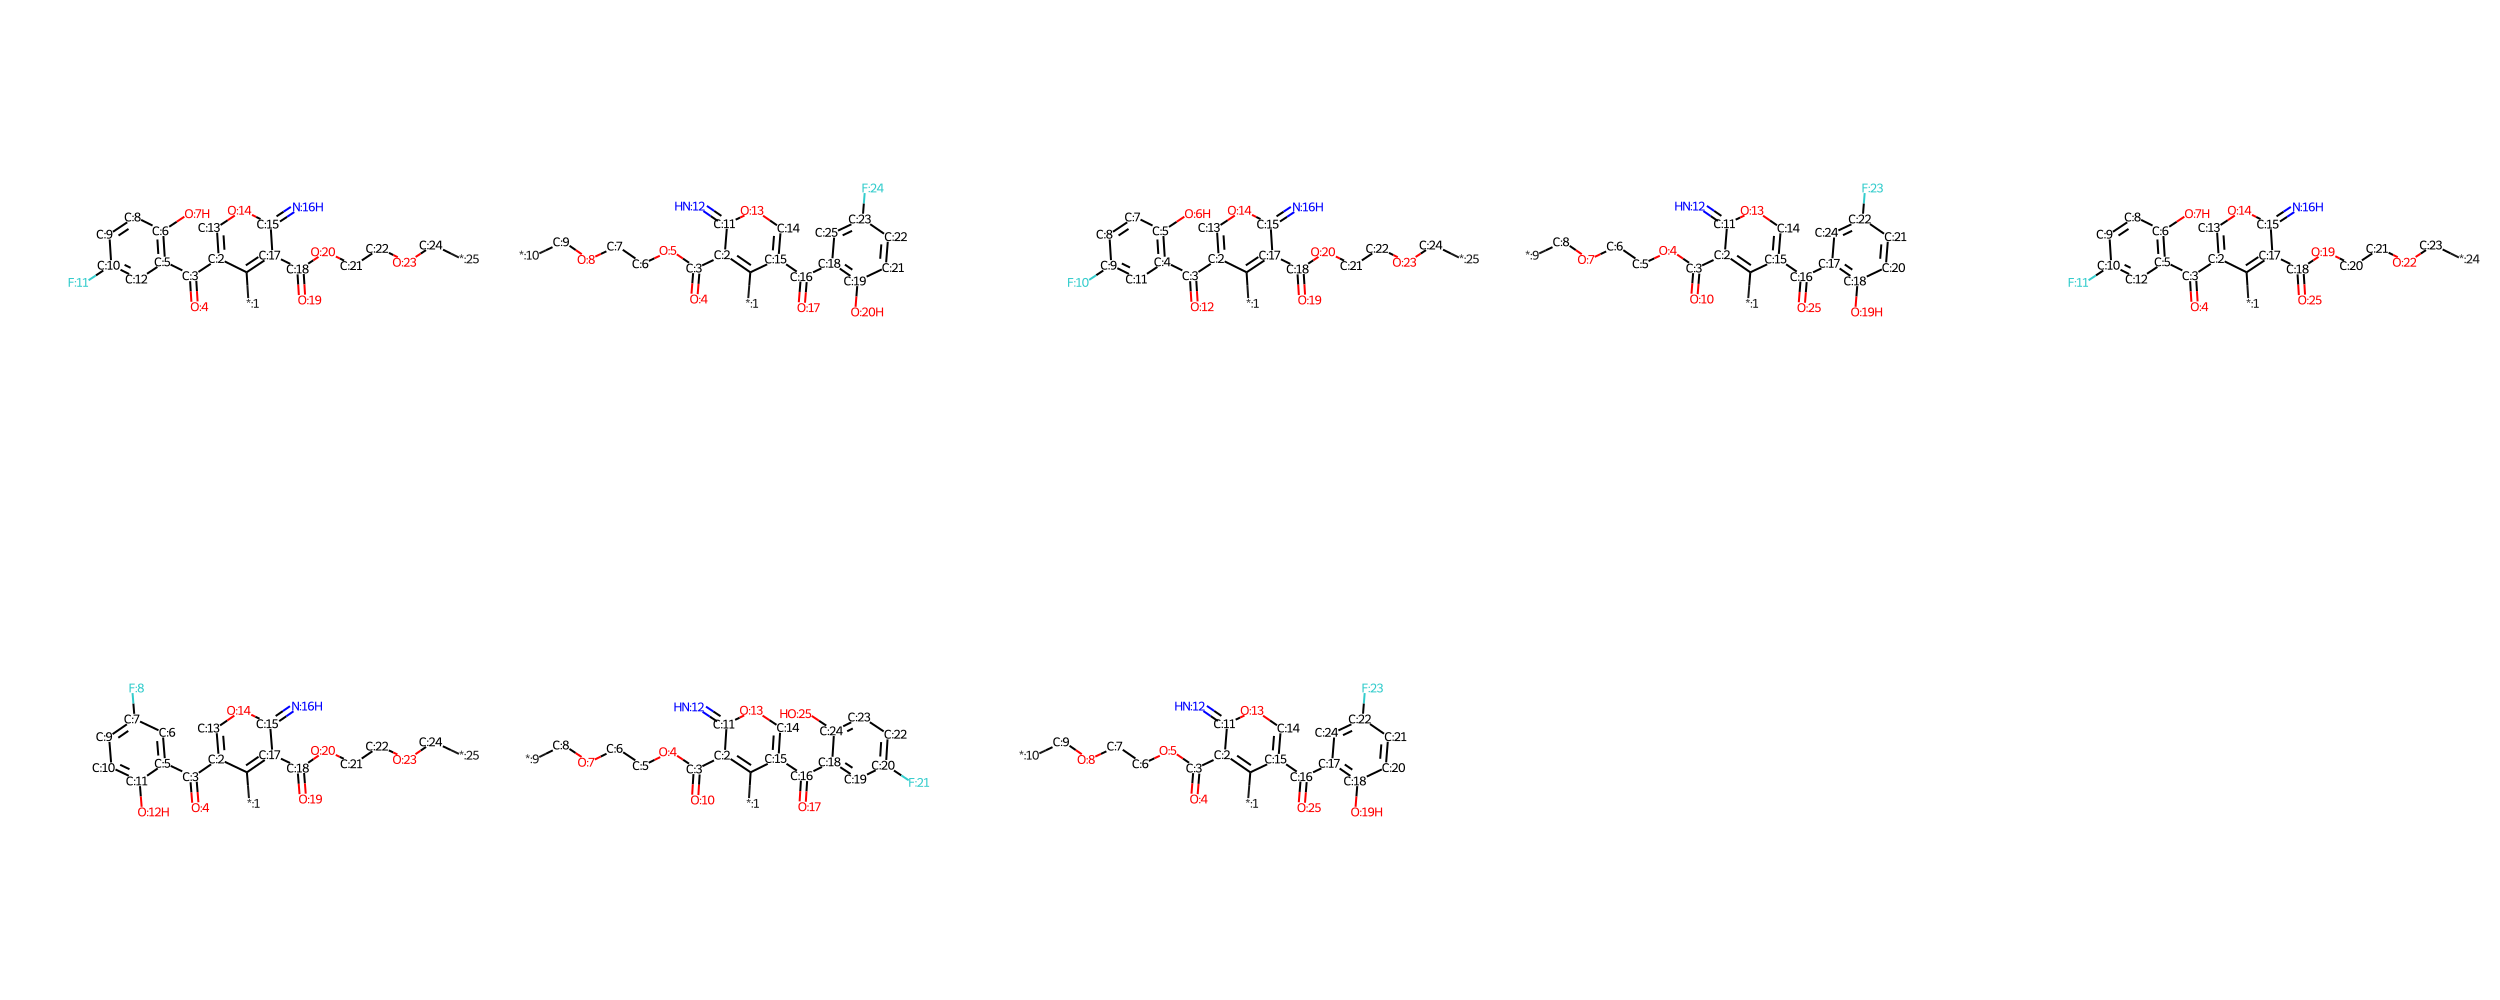

Reversed versions


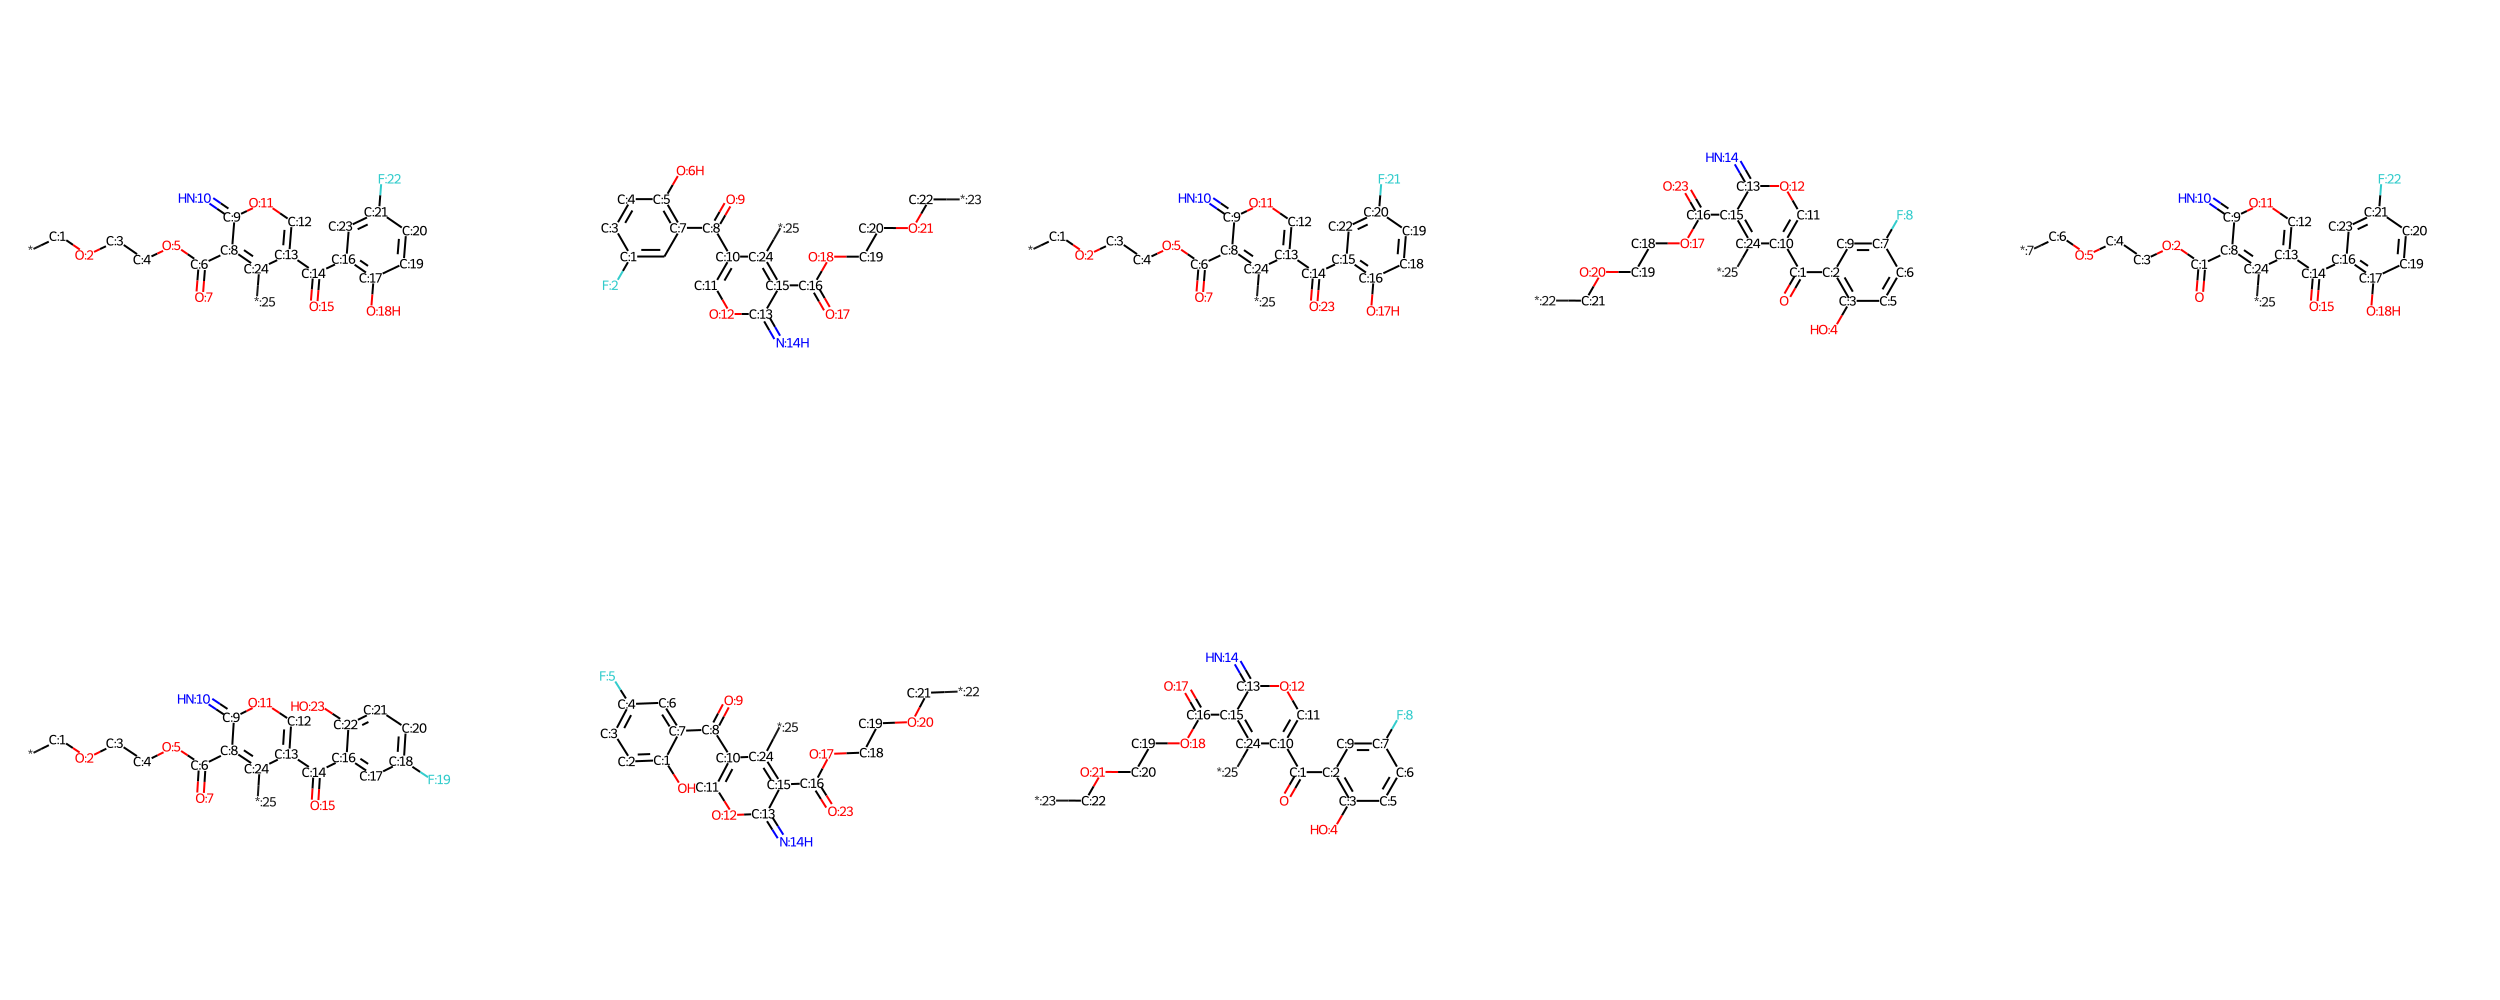

In [19]:
# Randomize at arbitrary root
tsmiles = test_smiles[1]
tsmiles = '*COCCOC(=O)c1c(*)c(C(=O)c2cc(F)ccc2O)coc1=N'
print(tsmiles)
display(mol_with_atom_index(Chem.MolFromSmiles(tsmiles)))
rand_smiles = utils.randomize_smiles(smi=tsmiles, random_type='restricted', rootAtom=9, reverse=False)
print('Randomized from same root')
print(rand_smiles)
display(Draw.MolsToGridImage(mols=[mol_with_atom_index(Chem.MolFromSmiles(randsmi)) for randsmi in rand_smiles], molsPerRow=5, subImgSize=(500,500)))
print('Reversed versions')
display(Draw.MolsToGridImage(mols=[mol_with_atom_index(Chem.MolFromSmiles(utils.reverse_smiles(smi, v=False))) for smi in rand_smiles], molsPerRow=5, subImgSize=(500,500)))

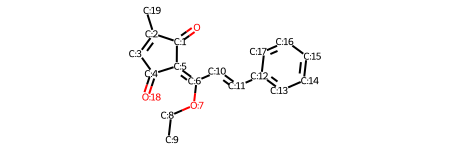

Reversing: O=C1C(=CC(C1=C(OCC)C=Cc2ccccc2)=O)C
Parenthesis identified:
	 [4, 33]
Parenthesis split:
	 ['O=C1', 'C(=CC(C1=C(OCC)C=Cc2ccccc2)=O)', 'C']
Tokenize outside:
	 ['O=', 'C1', 'C(=CC(C1=C(OCC)C=Cc2ccccc2)=O)', 'C']
Tokenize anything else:
	 ['O', '=', 'C1', 'C(=CC(C1=C(OCC)C=Cc2ccccc2)=O)', 'C']
Correct rings following square brackets:
	 ['O', '=', 'C1', 'C(=CC(C1=C(OCC)C=Cc2ccccc2)=O)', 'C']
Reversed tokens:
	 ['C', 'C(=CC(C1=C(OCC)C=Cc2ccccc2)=O)', 'C1', '=', 'O']
Reversed smiles:
	 CC(=CC(C1=C(OCC)C=Cc2ccccc2)=O)C1=O


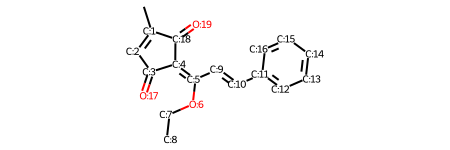

In [81]:
problem_smiles = [
    'O=C1C(=CC(C1=C(OCC)C=Cc2ccccc2)=O)C',
    'O=C1C(=CC(C1=C(C=Cc2ccccc2)OCC)=O)C',
    'O=C2C(=CC(=O)C2=C(OCC)C=Cc1ccccc1)C',
    'O=C1C(C)=CC(C1=C(C=Cc2ccccc2)OCC)=O'
]
psmi = problem_smiles[0]
display(mol_with_atom_index(Chem.MolFromSmiles(psmi)))
display(mol_with_atom_index(Chem.MolFromSmiles(reverse_smiles(psmi, v=True))))

In [84]:
for smi in problem_smiles:
    p, _ = test_smiles_eq(smi, reverse_smiles(smi, renumber_rings=True, v=True))
    print(p)

Reversing: O=C1C(=CC(C1=C(OCC)C=Cc2ccccc2)=O)C
Parenthesis identified:
	 [4, 33]
Parenthesis split:
	 ['O=C1', 'C(=CC(C1=C(OCC)C=Cc2ccccc2)=O)', 'C']
Tokenize outside:
	 ['O=', 'C1', 'C(=CC(C1=C(OCC)C=Cc2ccccc2)=O)', 'C']
Tokenize anything else:
	 ['O', '=', 'C1', 'C(=CC(C1=C(OCC)C=Cc2ccccc2)=O)', 'C']
Correct rings following square brackets:
	 ['O', '=', 'C1', 'C(=CC(C1=C(OCC)C=Cc2ccccc2)=O)', 'C']
Reversed tokens:
	 ['C', 'C(=CC(C1=C(OCC)C=Cc2ccccc2)=O)', 'C1', '=', 'O']
Reversed smiles:
	 CC(=CC(C1=C(OCC)C=Cc2ccccc2)=O)C1=O
Rings reindexed:
	 CC(=CC(C1=C(OCC)C=Cc2ccccc2)=O)C1=O
True
Reversing: O=C1C(=CC(C1=C(C=Cc2ccccc2)OCC)=O)C
Parenthesis identified:
	 [4, 33]
Parenthesis split:
	 ['O=C1', 'C(=CC(C1=C(C=Cc2ccccc2)OCC)=O)', 'C']
Tokenize outside:
	 ['O=', 'C1', 'C(=CC(C1=C(C=Cc2ccccc2)OCC)=O)', 'C']
Tokenize anything else:
	 ['O', '=', 'C1', 'C(=CC(C1=C(C=Cc2ccccc2)OCC)=O)', 'C']
Correct rings following square brackets:
	 ['O', '=', 'C1', 'C(=CC(C1=C(C=Cc2ccccc2)OCC)=O)', 'C']
Reve

## Setup prior

In [9]:
# Set device
device = utils.set_default_device_cuda('gpu')

# Load model
prior = Model.load_from_file(file_path='./data/ChEMBL28p_all_undersample-8_rand10_gru/Prior_ChEMBL28p_all_undersample-8_rand10_Epoch-10.ckpt', sampling_mode=True, device=device)

RDKit ERROR: [15:25:24] Can't kekulize mol.  Unkekulized atoms: 0 2 3 25 26 27 28 30 31
RDKit ERROR: 
RDKit ERROR: [15:25:24] SMILES Parse Error: unclosed ring for input: 'c1(Cl)c(OC)ccc2[nH]c(-c3ccc(S(=O)(N4CCN(C(C5C(C(=O)OC)C6CCCC5CCCC5)=O)CC4)cc3)=O)nc12'
RDKit ERROR: [15:25:24] SMILES Parse Error: extra open parentheses for input: 'n1(C)c(C(N2CC3CN(C(c4cc(CS(C)(=O)=O)cc(C(F)(F)F)c4)C3Cc3ccc4c(c23)CCO4)=O)nnn1'


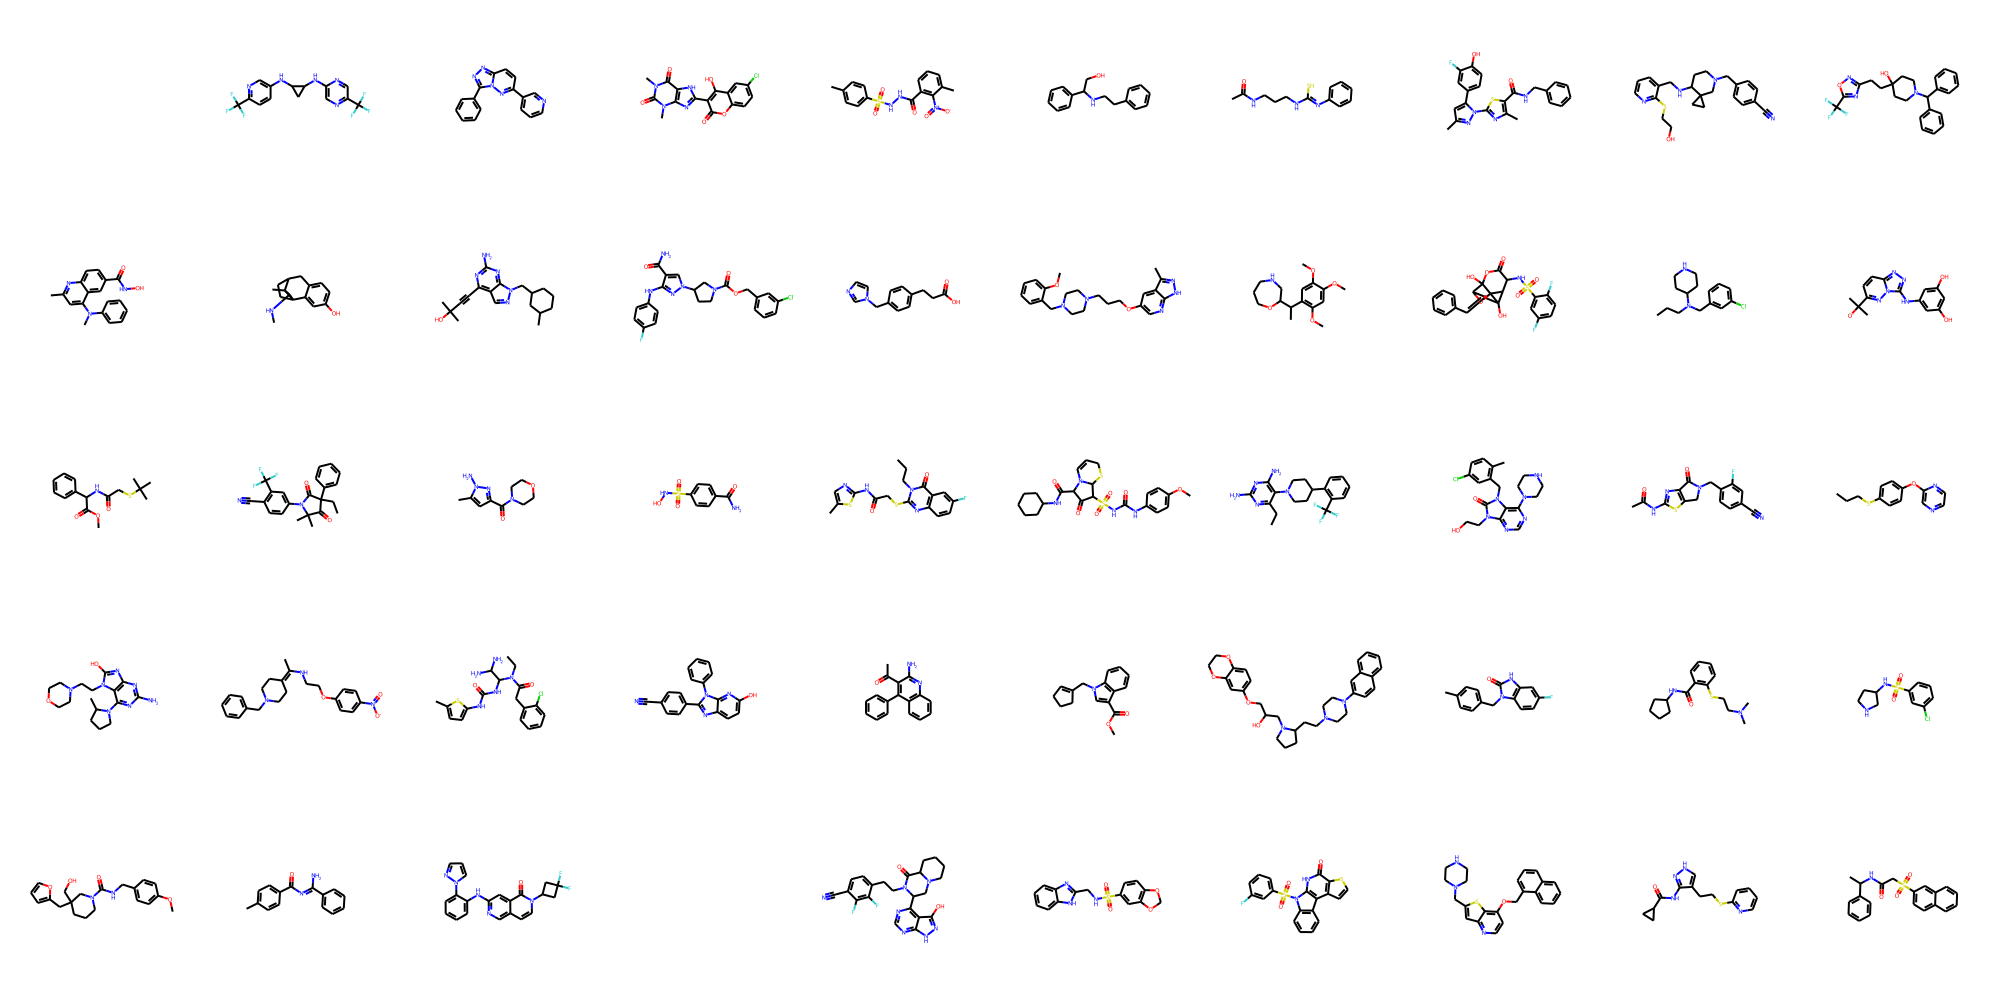

In [16]:
Draw.MolsToGridImage(mols=[Chem.MolFromSmiles(smi) for smi in prior.sample_smiles()[0]], molsPerRow=10)

## Sampling from batch input

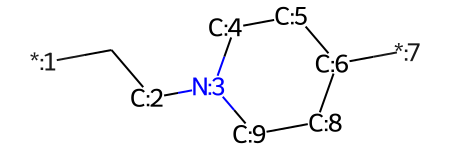

In [4]:
risperidone = "Cc1nc2n(c(=O)c1CCN1CCC(c3noc4cc(F)ccc34)CC1)CCCC2"
tsmiles = "C(*)CN1CCC(*)CC1"
mol = mol_with_atom_index(Chem.MolFromSmiles(tsmiles))
mol

In [2]:
def get_attachment_indexes(smi: str) -> list: # Utils
    """
    Identify atom idxs of attachment points (i.e., neighbours of *)
    :param smi: SMILES with (*) to denote where new atoms should be attached
    :return: Atom index of attachment points
    """
    mol = Chem.MolFromSmiles(smi)
    assert mol, "Error parsing partial smiles"
    attachment_points = []
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == "*":
            natom = atom.GetNeighbors()[0]
            attachment_points.append(natom.GetIdx())
    return attachment_points

def insert_attachment_points(smi: str, at_pts: list): # Utils
    """
    Insert * to denote where new atoms are to be attached, atom order may change as so new atom index is returned
    :param smi: SMILES without (*)
    :param at_pts: Atom index of attachment points
    :return: SMILES with (*), Atom index of attachment points
    """
    tokenizer = SMILESTokenizer()
    tokens = tokenizer.tokenize(smi, with_begin_and_end=False)
    atom_regexp = [
        tokenizer.REGEXPS["brackets"],
        tokenizer.REGEXPS["brcl"],
        tokenizer.REGEXPS["atom"]
        ]
    atom_counter = 0
    new_tokens = []
    for t in tokens:
        new_tokens.append(t)
        if any([regex.match(t) for regex in atom_regexp]):
            if atom_counter in at_pts:
                new_tokens.append("(*)")
            atom_counter += 1
    smi = ''.join(new_tokens)
    # Inserting these will change atom numbering so recaculate at_pts
    at_pts = get_attachment_indexes(smi)
    return smi, at_pts

def strip_attachment_points(smi: str):  # Utils
    """
    Remove * and provide canonical SMILES
    :param smi: SMILES with (*)
    :return: SMILES without (*), Atom index of attachment points
    """
    at_pts = get_attachment_indexes(smi)
    smi = smi.replace("(*)", "").replace("*", "")
    return smi, at_pts

def optimize_partial_smiles(smi: str, at_idx: int):  # Model
    """
    Optimize partial SMILES for a particular attachment index with respect to the current model
    :param smi: SMILES with (*)
    :param at_idx: Selected attachment index
    :return: SMILES without (*) with the attchment index as the last atom, respective NLL
    """
    # Possibly optimal smiles
    rand_smi = utils.randomize_smiles(smi, n_rand=10, random_type='restricted', rootAtom=at_idx, reverse=True)
    if rand_smi is None:
        return None, None
    # Run through prior (remove)
    with torch.no_grad():
        nlls = prior.likelihood_smiles([smi.replace("(*)", "").replace("*", "") for smi in rand_smi]).cpu().numpy()
    opt_idx = np.argmin(nlls)
    opt_smi = rand_smi[opt_idx]
    opt_nll = nlls[opt_idx]
    # TODO strip attachment points; remove last at_pt
    return opt_smi, opt_nll

In [5]:
print(get_attachment_indexes(tsmiles))
utils.randomize_smiles(tsmiles, n_rand=10, random_type='restricted', rootAtom=0, reverse=True)

[0, 6]


['*C(CN1CCC(*)CC1)', 'C1CC(*)CCN1CC(*)']

In [40]:
#def _sample(prior, batch_size=64, temperature=1.0, partial_smiles=None) -> \
#        Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, Union[torch.Tensor, None]]:
batch_size, temperature, partial_smiles = 64, 1.0, "C(*)CN1CCC(*)CC1"
    
sequences = torch.zeros((batch_size, prior.max_sequence_length), dtype=torch.long)
sequences[:, 0] = prior.vocabulary["^"] 
input_vector = sequences[:, 0] 
action_probs = torch.zeros((batch_size, prior.max_sequence_length), dtype=torch.float, requires_grad=True) 
action_log_probs = torch.zeros((batch_size, prior.max_sequence_length), dtype=torch.float, requires_grad=True) 
values = torch.zeros((batch_size, prior.max_sequence_length), dtype=torch.float, requires_grad=True) \
    if prior.network._get_name() == 'RNNCritic' else None
hidden_state = None
nlls = torch.zeros(batch_size)

if partial_smiles is not None:
    # Find attachment points
    at_pts = get_attachment_indexes(partial_smiles)
    n_pts = len(at_pts)
    # Optimize smiles for each attachment point TODO
    # Select attachment points TODO @ random
    attachment_memory = [at_pts]*batch_size
    sel_pt = np.random.choice(at_pts)
    print(f'Selecting: {sel_pt} of {at_pts}')
    opt_smi, opt_nll = optimize_partial_smiles(partial_smiles, sel_pt)
    print(f'Optimal smiles: {opt_smi} with {opt_nll}')
    opt_smi, at_pts = strip_attachment_points(opt_smi)
    at_pts.pop(-1) # Remove attachment point used (last one)
    n_pts -= 1
    print(f'Stripped smiles: {opt_smi} with remaining points @ {at_pts}')
    tokens = prior.tokenizer.tokenize(opt_smi)
    encoded = torch.tensor(prior.vocabulary.encode(tokens), dtype=torch.long)
    pseq = torch.zeros((batch_size, prior.max_sequence_length), dtype=torch.long, requires_grad=False)
    pseq[:, :len(encoded)] = encoded.repeat(batch_size, 1)

t = 1
while t < prior.max_sequence_length:
#for t in range(1, prior.max_sequence_length-1):
    print(t)
    # Sample
    logits, value, hidden_state = prior.network(input_vector.unsqueeze(1), hidden_state)
    logits = logits.squeeze(1) / temperature
    probabilities = logits.softmax(dim=1)
    log_probs = logits.log_softmax(dim=1)
    input_vector = torch.multinomial(probabilities, 1).view(-1)
    
    # Enforce sampling
    if partial_smiles is not None:
        enforce = (pseq[:, t] != 0)
        input_vector = (~enforce * input_vector) + (enforce * pseq[:, t])
    
    # Update values
    sequences[:, t] = input_vector
    action_probs.data[:, t] = torch.tensor([p[a] for p, a in zip(probabilities, input_vector)])
    action_log_probs.data[:, t] = torch.tensor([p[a] for p, a in zip(log_probs, input_vector)])
    if prior.network._get_name() == 'RNNCritic':
        values.data[:, t] = value.squeeze(-1) 
    nlls += prior._nll_loss(log_probs, input_vector)

    # Move on to next time step
    if input_vector.sum() == 0:
        #print(sequences[:, t-10:t])
        if (partial_smiles is not None) and (n_pts > 0):
            #print(f'Suffling as {n_pts}')
            # Convert back everything to smiles
            current_smiles = [prior.tokenizer.untokenize(prior.vocabulary.decode(seq)) for seq in sequences.cpu().numpy()]
            # Insert remaining attachment points
            for i, smi in enumerate(current_smiles):
                if not Chem.MolFromSmiles(smi):
                    pseq[i, :] = sequences.data[i, :]
                    # Update pseq with current seq
                    continue
                par_smi, par_pts = insert_attachment_points(smi, attachment_memory[i])
                #print(f'{par_smi} {par_pts}')
                # Optimize smiles
                sel_pt = np.random.choice(par_pts)
                opt_smi, opt_nll =  optimize_partial_smiles(par_smi, sel_pt)
                #print(f'{opt_smi} {opt_nll}')            
                # Save remaining pts
                opt_smi, rm_pts = strip_attachment_points(opt_smi)
                # Update attachment memory
                rm_pts.pop(-1)
                attachment_memory[i] = rm_pts
                #print(f'{opt_smi} {rm_pts}') 
                # Update pseq
                encoded = torch.zeros(prior.max_sequence_length, dtype=torch.long, requires_grad=False)
                encoding = torch.tensor(prior.vocabulary.encode(prior.tokenizer.tokenize(opt_smi)), dtype=torch.long)
                encoded[:len(encoding)] = encoding
                pseq[i, :len(encoded)] = encoded
                #print(f'New pseq: {encoded}') 
            # Start afresh
            hidden_state = None
            n_pts -= 1
            t = 1
        else:
            break
    else:
        t += 1

    #return sequences.data, nlls, action_probs, action_log_probs, values

Selecting: 0 of [0, 6]
Optimal smiles: C1CC(*)CCN1CC(*) with 18.87148666381836
Stripped smiles: C1CCCCN1CC with remaining points @ [2]
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
Suffling as 1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


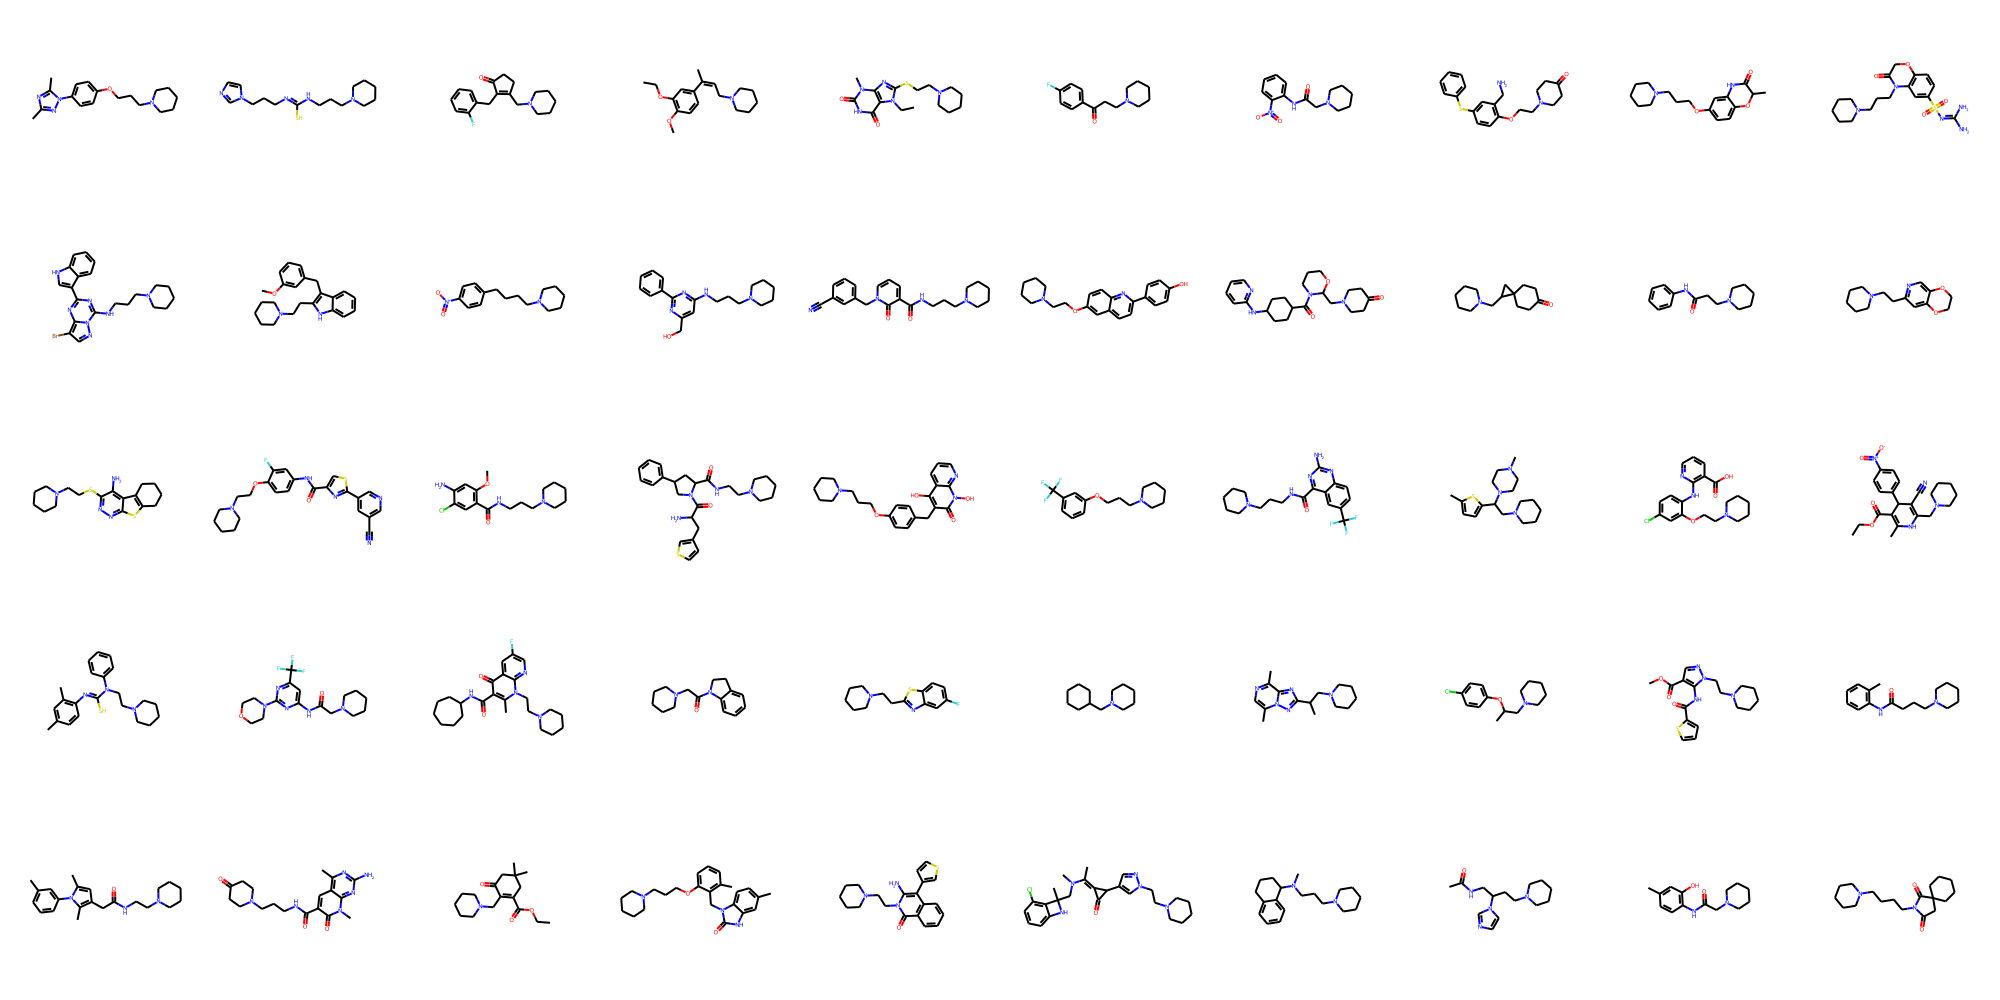

In [41]:
sample_smiles = [prior.tokenizer.untokenize(prior.vocabulary.decode(seq)) for seq in sequences.cpu().numpy()]
display(Draw.MolsToGridImage(mols=[Chem.MolFromSmiles(smi) for smi in sample_smiles], molsPerRow=10))

['C1CC(c2nc3c(cc(F)cc3-c3cc4c(cc3)OCC4=O)n2CCOC)CCN1CCNC', 'C1CC(C)(C(=O)NC2CCC(Nc3nc4c(s3)CCC(C)C4)CC2)CCN1CC#C', 'C1CC(N2C(=O)N(C)C3C2C(c2cc(OC)ccc2)=NO3)CCN1CCC1=Cc2ccccc2C1', 'C1CC(N2CCN(c3nccc(Nc4cc(NC(c5cnc(C(F)(F)F)cc5)=O)ccc4F)n3)CC2)CCN1CC', 'C1CC(N(Cc2cccs2)C(=O)Nc2cccc3[nH]ncc23)CCN1CC', 'C1CC(Cn2c3[nH]c(CCC)c(Cl)c3c3c(c2=O)N2C(CO3)CC2=O)CCN1CC(=O)N', 'C1CC(c2[nH]c3ncc(Br)c(C)c3n2)CCN1CC(=O)N(C)c1sc2c(cccn2)n1', 'C1CC(c2ccc(NS(=O)(c3cccc4c3nccc4)=O)cc2)CCN1CCN(C)C', 'C1CC(n2c(=O)n(C)c(=O)c3nc(N4CCOCC4C)nc(Nc4cc(Cl)c(F)cc4)c23)CCN1CCn1c(C)cc2ccccc12', 'C1CC(N2CCc3c(cccc3)C2)CCN1CCC(=O)Nc1cccc(C)c1', 'C1CC(c2c3cccc4c3c(cc2)CN(C)C4)CCN1CC=C', 'C1CC2(OCCO2)CCN1CCCOc1ccc(Cc2ccccc2)cc1', 'C1CC(Oc2ccc3c(c2)-c2onc(C(=O)OC)c2CC3)CCN1CC(N(C)C)=O', 'C1CC(NC(=O)c2c3ccccc3nc(NC(c3ccc(N(C)C)cc3)=O)c2)CCN1CC', 'C1CC2(OC(CCN(C)C)c3cccc(F)c32)CCN1CC1CC1', 'C1CC(c2[nH]c3cccnc3c2C(NCC2CC2)=O)CCN1CCc1ccc2c(c1)COC2=O', 'C1CC(c2ccc(C(C)C)cc2)CCN1CCN1C(=O)CC(C(=O)NCC#N)C1', 'C1CC2(OC(Nc3ncnc4c3cc(

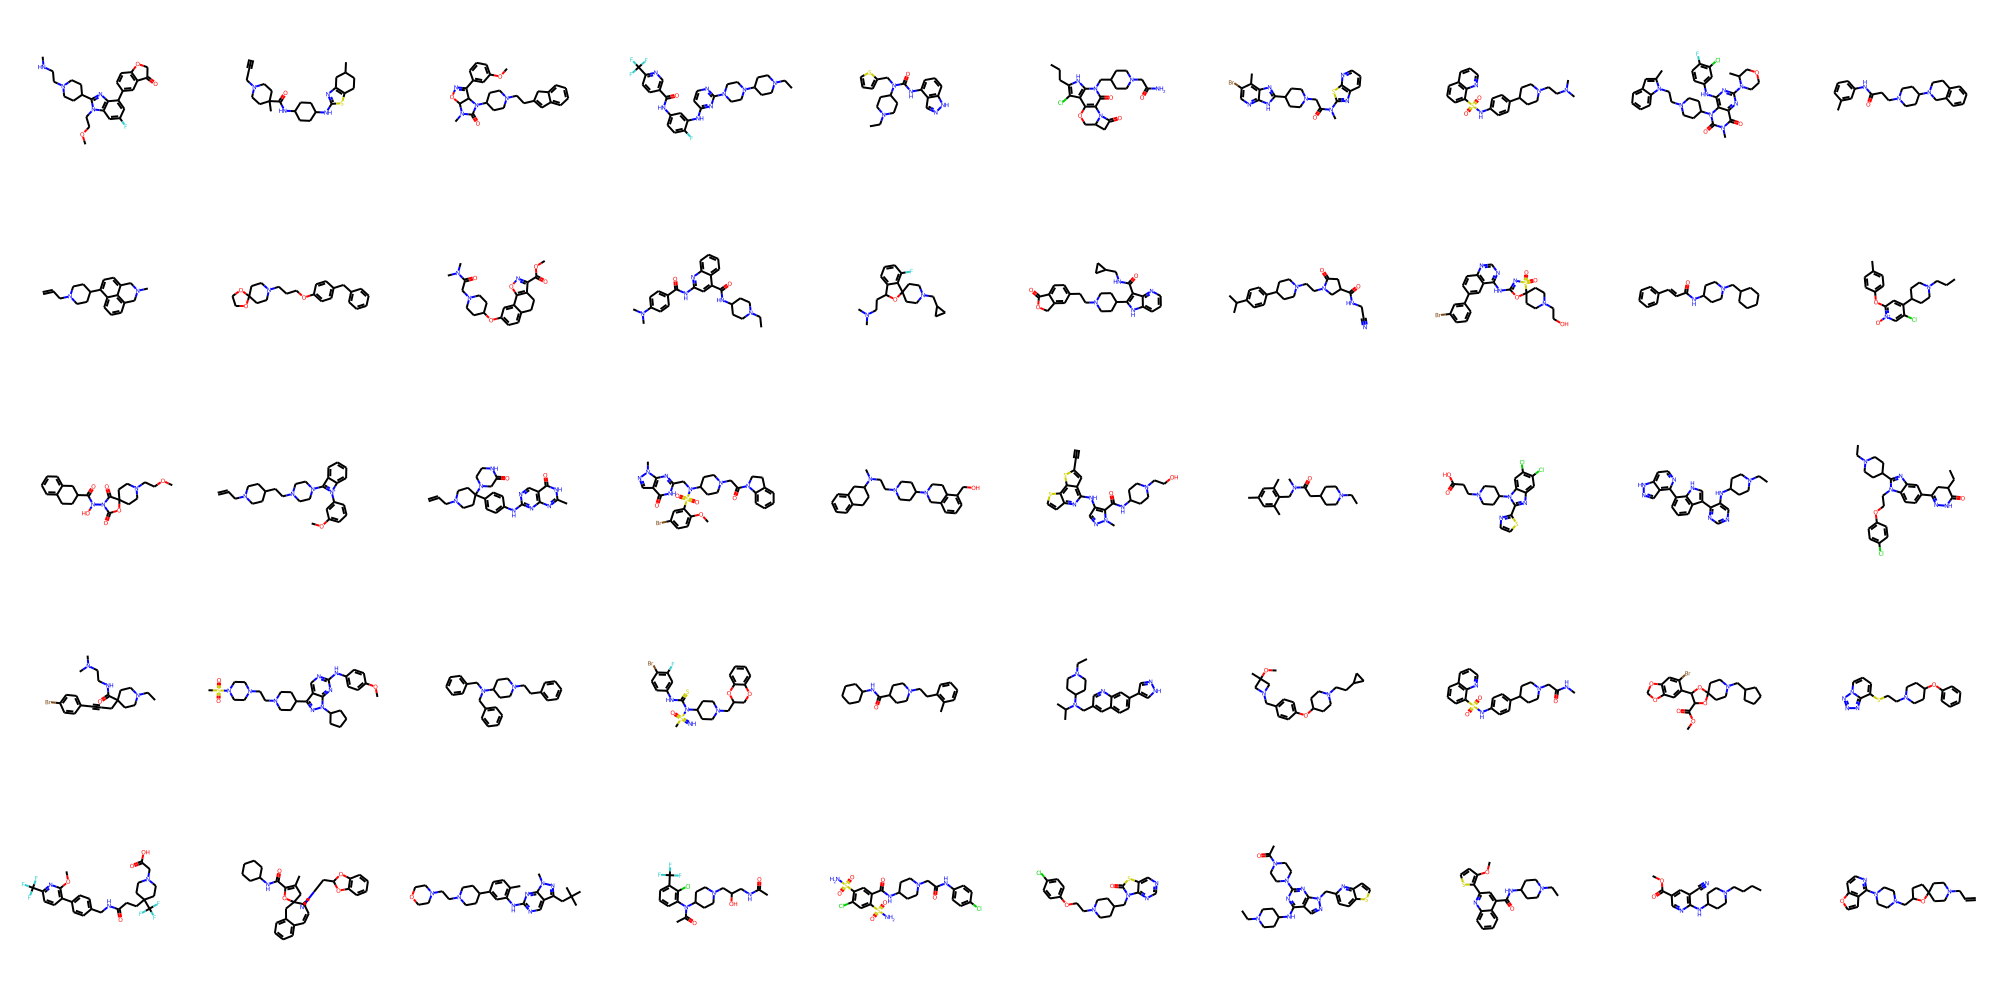

KeyError: '+'

In [234]:
# Convert sequences to SMILES
sample_smiles = [prior.tokenizer.untokenize(prior.vocabulary.decode(seq)) for seq in sequences.cpu().numpy()]
print(sample_smiles)
display(Draw.MolsToGridImage(mols=[Chem.MolFromSmiles(smi) for smi in sample_smiles], molsPerRow=10))
# Insert (*) at attachment points TODO
# Optimize smiles for a different attachment point
err_idxs = []
opt_smiles = []
opt_seqs = torch.zeros((batch_size, prior.max_sequence_length), dtype=torch.long)
for i, smi in enumerate(sample_smiles):
    opt_smi, _, _, = optimize_smiles(smi, 4)
    if opt_smi is None:
        err_idxs.append(i)
        opt_smiles.append(smi)
        opt_seq = torch.tensor(prior.vocabulary.encode(prior.tokenizer.tokenize(smi)), dtype=torch.long)
        opt_seqs[i, 0:len(opt_seq)] = opt_seq
    else:
        opt_smiles.append(opt_smi)
        opt_seq = torch.tensor(prior.vocabulary.encode(prior.tokenizer.tokenize(opt_smi)), dtype=torch.long)
        opt_seqs[i, 0:len(opt_seq)] = opt_seq


In [220]:
enforce

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False])